[![Open in Colab](https://colab.research.google.com/assets/colab-badge.svg)](https://colab.research.google.com/github/langchain-ai/langchain-academy/blob/main/module-1/agent-memory.ipynb) [![Open in LangChain Academy](https://cdn.prod.website-files.com/65b8cd72835ceeacd4449a53/66e9eba12c7b7688aa3dbb5e_LCA-badge-green.svg)](https://academy.langchain.com/courses/take/intro-to-langgraph/lessons/58239417-lesson-7-agent-with-memory)

# 1.5 Agent memory

## 回顾

之前，我们构建了一个可以执行以下操作的代理：

- `act`：让模型调用特定工具
- `observe`：将工具输出传回模型
- `reason`：让模型根据工具输出进行推理，决定下一步操作（例如，调用另一个工具或直接响应）。


![Screenshot 2024-08-21 at 12.45.32 PM.png](https://cdn.prod.website-files.com/65b8cd72835ceeacd4449a53/66dbab7453080e6802cd1703_agent-memory1.png)

## Goals

现在，我们将通过引入记忆来扩展我们的代理。

In [10]:
%%capture --no-stderr
%pip install --quiet -U langchain_openai langchain_core langgraph

In [11]:
## Set OpenAI API Key
import os, getpass

def _set_env(var: str):
    if not os.environ.get(var):
        os.environ[var] = getpass.getpass(f"{var}: ")

_set_env("OPENAI_API_KEY")

我们将使用 [LangSmith](https://docs.smith.langchain.com/) 进行中间结果的追踪 [tracing](https://docs.smith.langchain.com/concepts/tracing).

In [12]:
_set_env("LANGCHAIN_API_KEY")
os.environ["LANGCHAIN_TRACING_V2"] = "true"
os.environ["LANGCHAIN_PROJECT"] = "langchain-academy"

This follows what we did previously.

In [13]:
## 定义了 3 个工具函数
from langchain_openai import ChatOpenAI

def multiply(a: int, b: int) -> int:
    """Multiply a and b.

    Args:
        a: first int
        b: second int
    """
    return a * b

# This will be a tool
def add(a: int, b: int) -> int:
    """Adds a and b.

    Args:
        a: first int
        b: second int
    """
    return a + b

def divide(a: int, b: int) -> float:
    """Divide a and b.

    Args:
        a: first int
        b: second int
    """
    return a / b

tools = [add, multiply, divide]
llm = ChatOpenAI(model="gpt-4o")
llm_with_tools = llm.bind_tools(tools) # 绑定工具函数

Review: `MessagesState` is defined with
- `a single messages key` which is a list of 
- `AnyMessage objects` and uses the 
- `add_messages reducer`. 

In [14]:
## 定义了一个 assistant agent
from langgraph.graph import MessagesState
from langchain_core.messages import AIMessage, HumanMessage, SystemMessage

# System message
sys_msg = SystemMessage(content="You are a helpful assistant tasked with performing arithmetic on a set of inputs.")

# Node
def assistant(state: MessagesState): # state 
   return {"messages": [llm_with_tools.invoke([sys_msg] + state["messages"])]}

## state 是一个 MessagesState 对象，存储了对话历史
## state["messages"] 是对话的消息列表，可能包含用户消息 (HumanMessage) 和之前的助手回复 (AIMessage)
## 列表相加，将 sys_msg 添加到 state["messages"] 的开头，构成完整的消息序列
## 将 sys_msg (系统设定) 和对话历史 (state["messages"]) 组合，形成完整的消息上下文。
## 调用 llm_with_tools.invoke，发送上下文给模型，让其基于这些信息生成回复。


#state["messages"] = [
#    SystemMessage(content="You are a helpful assistant."),
#    HumanMessage(content="What is 2 + 2?"),
#    AIMessage(content="The answer is 4."),
#]

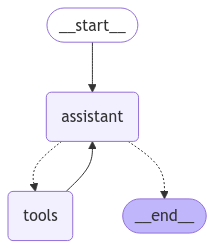

In [15]:
## 创建一个图
from langgraph.graph import START, StateGraph
from langgraph.prebuilt import tools_condition, ToolNode
from IPython.display import Image, display

# Graph
builder = StateGraph(MessagesState)

# Define nodes: these do the work
builder.add_node("assistant", assistant)
builder.add_node("tools", ToolNode(tools))

# Define edges: these determine how the control flow moves
builder.add_edge(START, "assistant")
builder.add_conditional_edges(
    "assistant",
    # If the latest message (result) from assistant is a tool call -> tools_condition routes to tools
    # If the latest message (result) from assistant is a not a tool call -> tools_condition routes to END
    tools_condition,
)
builder.add_edge("tools", "assistant") ## 从 tools 节点返回 assistant 节点，形成闭环
react_graph = builder.compile()

# Show
display(Image(react_graph.get_graph(xray=True).draw_mermaid_png()))

## Memory

首先，让我们先和以前一样运行这个图。

In [16]:
## 运行图
messages = [HumanMessage(content="Add 3 and 4.")]
messages = react_graph.invoke({"messages": messages})
for m in messages['messages']:
    m.pretty_print()

================================ Human Message =================================

Add 3 and 4.
================================== Ai Message ==================================
Tool Calls:
  add (call_6dFMMxFZLKYRbDlOzL536Cus)
 Call ID: call_6dFMMxFZLKYRbDlOzL536Cus
  Args:
    a: 3
    b: 4
================================= Tool Message =================================
Name: add

7
================================== Ai Message ==================================

The sum of 3 and 4 is 7.


现在，进行一个 x2 的运算。

In [17]:
messages = [HumanMessage(content="Multiply that by 2.")]
messages = react_graph.invoke({"messages": messages})
for m in messages['messages']:
    m.pretty_print()

================================ Human Message =================================

Multiply that by 2.
================================== Ai Message ==================================

It looks like I need more information to perform the multiplication. Could you please specify what number you'd like to multiply by 2?


我们无法保留初始对话中数字 7 的记忆！

这是因为状态是暂时的 [state is transient](https://github.com/langchain-ai/langgraph/discussions/352#discussioncomment-9291220)，仅限于单次图形执行。

当然，这限制了我们在多轮对话中处理中断的能力。

我们可以使用持久化 [persistence](https://langchain-ai.github.io/langgraph/how-tos/persistence/)功能来解决这个问题！

LangGraph 可以使用`检查点工具 checkpointer` 在每一步后自动保存图形状态。

这种内置的持久化层为我们提供了记忆功能，使 LangGraph 能够从上次状态更新中继续。

最简单的`检查点工具`之一是 `MemorySaver`，它是一个用于存储图形状态的`内存键值对存储`。

我们只需用`检查点工具`编译图形，图形就具备了记忆功能！

In [21]:
## 引入 检查点工具 MemorySaver
from langgraph.checkpoint.memory import MemorySaver
memory = MemorySaver()
react_graph_memory = builder.compile(checkpointer=memory)

当我们使用记忆功能时，需要指定一个 `thread_id`。

这个 `thread_id` 将用于存储我们的图形状态集合。

以下是一个简单示意：

- 检查点工具会在图形的每一步写入状态。
- 这些检查点会被保存在一个线程中。
- 未来，我们可以通过 thread_id 访问该线程。

![state.jpg](https://cdn.prod.website-files.com/65b8cd72835ceeacd4449a53/66e0e9f526b41a4ed9e2d28b_agent-memory2.png)


In [22]:
## 指定一个 thread
config = {"configurable": {"thread_id": "1"}}

## 指定人类的问题输入
messages = [HumanMessage(content="Add 3 and 4.")]

## 运行图
messages = react_graph_memory.invoke({"messages": messages},config)
for m in messages['messages']:
    m.pretty_print()

================================ Human Message =================================

Add 3 and 4.
================================== Ai Message ==================================
Tool Calls:
  add (call_U0nj8olDVVX66a8dK2OAFJZH)
 Call ID: call_U0nj8olDVVX66a8dK2OAFJZH
  Args:
    a: 3
    b: 4
================================= Tool Message =================================
Name: add

7
================================== Ai Message ==================================

The sum of 3 and 4 is 7.


如果我们传递相同的 `thread_id`，那么我们可以从之前记录的`状态检查点`继续！

在这种情况下，`上述对话会被记录`到线程中。

我们传递的 `HumanMessage`（如 "Multiply that by 2."）会被追加到上述对话中。

因此，模型现在知道 `"that"` 指的是 `The sum of 3 and 4 is 7`。

In [ ]:
## 通过 config 和 thread_id 指定了一个线程，这样就可以使用之前的对话历史
messages = [HumanMessage(content="Multiply that by 2.")]
messages = react_graph_memory.invoke({"messages": messages}, config)
for m in messages['messages']:
    m.pretty_print()

================================ Human Message =================================

Add 3 and 4.
================================== Ai Message ==================================
Tool Calls:
  add (call_8jN91BhEIuXx8fFMlcx0Fw6t)
 Call ID: call_8jN91BhEIuXx8fFMlcx0Fw6t
  Args:
    a: 3
    b: 4
================================= Tool Message =================================
Name: add

7
================================== Ai Message ==================================

The sum of 3 and 4 is 7.
================================ Human Message =================================

Multiply that by 2.
================================== Ai Message ==================================
Tool Calls:
  multiply (call_PqXssRSm3YYR406fcHY7h3us)
 Call ID: call_PqXssRSm3YYR406fcHY7h3us
  Args:
    a: 7
    b: 2
================================= Tool Message =================================
Name: multiply

14
================================== Ai Message ==================================

The result of multipl

In [ ]:
# END